In [22]:
## PACKAGES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from IPython.display import display, clear_output

import sys
sys.path.insert(1,'/home/shelia/AllFiles/Research_tuly/pyDeepInsight/pyDeepInsight_SRT/')
from pyDeepInsight import ImageTransformer, CAMFeatureSelector

In [23]:
##LOAD DATA
expr_file = r"../data/Survival_TCGA_VS_Desmd/modified_TCGA_BRCA_log2.csv"
expr = pd.read_csv(expr_file, encoding='utf-8', engine='python')
expr=expr.transpose()
expr.columns=expr.iloc[0]
X = expr.iloc[1:,1:-1].values
X=X.astype(float)
Y = expr.iloc[1:,-1].values
genes = expr.iloc[:,:-1].columns.to_numpy()


In [24]:
random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.2, shuffle=True, stratify=Y)

In [25]:
y_train

array(['long', 'long', 'short', 'short', 'long', 'short', 'short', 'long',
       'short', 'short', 'short', 'long', 'short', 'short', 'short',
       'long', 'long', 'long', 'long', 'short', 'long', 'long', 'short',
       'short', 'short', 'short', 'short', 'long', 'long', 'long',
       'short', 'long', 'long', 'short', 'short', 'short', 'short',
       'long', 'short', 'long', 'short', 'long', 'long', 'short', 'short',
       'long', 'short', 'long', 'short', 'short', 'short', 'short',
       'short', 'short', 'short', 'short', 'short', 'short', 'short',
       'short', 'short', 'short', 'short', 'short', 'short', 'short',
       'short', 'short', 'long', 'short', 'long', 'short', 'long',
       'short', 'long', 'short', 'short', 'short', 'long', 'long', 'long',
       'long', 'long', 'short', 'short', 'long', 'short', 'long', 'long',
       'short', 'short', 'long', 'long', 'short', 'short', 'short',
       'short', 'short', 'long', 'short', 'long', 'short', 'short',
       'short

Remove low variance data. In this case the bottom 30%.

In [26]:
var_filter = X.var(0) >= np.percentile(X.var(0), 30., method='nearest')

In [27]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_test_norm = mms.transform(X_test[:, var_filter])


Encode the classes

In [29]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

#### Why we use fit_transform() on training data but transform() on the test data?

The fit_transform method calculates the mean and the variance of each features in the data and transforms all the features using the respective mean and variance. If we will use the fit method on our test data too, we will compute a new mean and variance that is a new scale for each feature and will let our model learn about our test data too. Thus, what we want to keep as a surprise is no longer unknown to our model and we will not get a good estimate of how our model is performing on the test (unseen) data which is the ultimate goal of building a model using machine learning algorithm.

This is the standard procedure to scale our data while building a machine learning model so that our model is not biased towards a particular feature of the dataset and at the same time prevents our model to learn the features/values/trends of our test data.

In [32]:
num_classes
np.sum(y_test_enc==1)

20

## DeepInsight Image Transformation
Convert data to image format using DeepInsight

In [33]:
reducer = umap.UMAP(
    n_neighbors=40,
    n_components=2,
    min_dist=0.99,
    metric='cosine',
    n_jobs=-1,
    ##random_state=42
)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor="PCA",
    pixels=pixel_size)

printing chvertices


/home/shelia/AllFiles/Research_tuly/pyDeepInsight/pyDeepInsight_SRT/pyDeepInsight/image_transformer.py:276: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


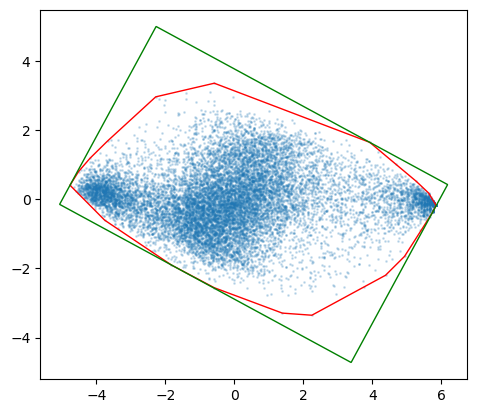

In [34]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

## CNN Image Classification
Train ResNet50 CNN

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## U-net Based Classifiation:

In [36]:
class CNN(torch.nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.model = torch.nn.Sequential( 
            #Input = 3 x 256 x 256, Output = 224 x 224 x 224 
            torch.nn.Conv2d(in_channels = 3, out_channels = 224, kernel_size = 3, padding = 1),  
            torch.nn.ReLU(), 
            #Input = 256 x 256 x 256, Output = 256 x 128 x 128 
            torch.nn.MaxPool2d(kernel_size=4), 
           
            

            torch.nn.Conv2d(in_channels = 224, out_channels = 56, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(), 
            # # #Input = 512 x 16 x 16 , Output = 512 x 8 x 8  
            torch.nn.MaxPool2d(kernel_size=4),
            # # # torch.nn.ReLU(), 
            # # # torch.nn.MaxPool2d(kernel_size=2),

  
            torch.nn.Flatten(), 
            torch.nn.Linear(56*14*14, 64), 
            torch.nn.ReLU(), 
            torch.nn.Linear(64, 2) 
        ) 
        self.layers=[]
  
    def forward(self, x): 
        input_shape=x.shape
        self.layers=[(0,input_shape)]

        for i,layer in enumerate(self.model):
            x=layer(x)
            output_shape=x.shape
            self.layers.append((i+1,output_shape))
        
        return x

In [37]:
#Selecting the appropriate training device 
model = CNN().to(device)

batch_size=10
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


In [38]:
#Defining the model hyper parameters 
num_epochs = 3
learning_rate = 0.005
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

#Training process begins 
train_loss_list = [] 
for epoch in range(num_epochs): 
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ') 
	train_loss = 0
	
	#Iterating over the training dataset in batches 
	model.train() 
	for i, (images, labels) in enumerate(trainloader): 
		
		#Extracting images and target labels for the batch being iterated 
		images = images.to(device) 
		labels = labels.to(device) 

		#Calculating the model output and the cross entropy loss 
		outputs = model(images) 
		loss = criterion(outputs, labels) 

		#Updating weights according to calculated loss 
		optimizer.zero_grad() 
		loss.backward() 
		optimizer.step() 
		train_loss += loss.item() 
	
	#Printing loss for each epoch 
	train_loss_list.append(train_loss/len(trainloader)) 
	print(f"Training loss = {train_loss_list[-1]}") 
	


Epoch 1/3: Training loss = 2.3326853742966285
Epoch 2/3: Training loss = 0.6545667396141932
Epoch 3/3: Training loss = 0.769602541740124


In [39]:
test_acc=0
model.eval() 
output_res=[]
output_origin=[]
  
with torch.no_grad(): 
    #Iterating over the training dataset in batches 
    for i, (images, labels) in enumerate(testloader): 
          
        images = images.to(device) 
        y_true = labels.to(device) 
        output_origin.extend(y_true.cpu().numpy())
          
        #Calculating outputs for the batch being iterated 
        outputx= model(images) 
          
        #Calculated prediction labels from models 
        _, y_pred = torch.max(outputx.data, 1) 
        output_res.extend(y_pred.cpu().numpy())
          
        #Comparing predicted and true labels 
        test_acc += (y_pred == y_true).sum().item() 
      
print(f"Test set accuracy = {100 * test_acc / len(X_test_img)} %")

Test set accuracy = 64.51612903225806 %


<Axes: >

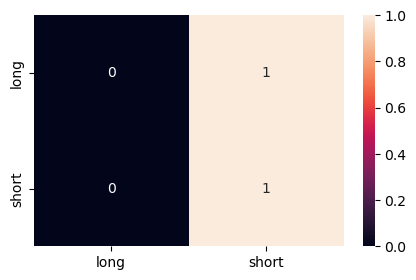

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classes=('long','short')
cf_matrix = confusion_matrix(output_origin, output_res)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

In [41]:
output_res

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
net = timm.create_model('resnet50', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

In [ ]:
batch_size=10
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 23.64 GiB total capacity; 3.37 GiB already allocated; 53.88 MiB free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
criterion = nn.CrossEntropyLoss()
##optimizer = optim.SGD(net.parameters(),lr=1e-02,momentum=2,)
optimizer = optim.Adam(net.parameters(),lr=0.0001)

In [ ]:
net.train()
for epoch in range(100):
    for i, (inputs, labels) in enumerate(trainloader):
        clear_output(wait=True)
        display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

'Epoch 000, batch 000'

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 23.64 GiB total capacity; 3.28 GiB already allocated; 55.88 MiB free; 3.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()

with torch.no_grad():
    y_hat = net(X_train_tensor)
train_predicted = torch.max(y_hat, 1)[1]

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())
print(f"The train accuracy was {accuracy_score(train_predicted.cpu(), y_train_enc):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")



The train accuracy was 1.000
The test accuracy was 0.645


## SqueezeNet

In [ ]:
import torchvision
device1 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_sq = torchvision.models.squeezenet1_1(weights='DEFAULT')
model_sq.classifier.append(nn.Flatten())
_ = model_sq.classifier.append(nn.Linear(1000, num_classes))

##transforming image to tensor
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
X_train_tensor_sq = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor_sq = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor_sq = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor_sq = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [ ]:
batch_size = 10

trainset = TensorDataset(X_train_tensor_sq, y_train_tensor_sq)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor_sq, y_test_tensor_sq)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model_sq.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

## DeepFeature: CAM-based Feature Selection

In [ ]:
model_sq.train()
model_sq.to(device1)
for epoch in range(120):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device1)
        labels = labels.to(device1)

        outputs = model_sq(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')

[0] loss: 0.858
[20] loss: 0.617
[40] loss: 0.587
[60] loss: 0.265
[80] loss: 0.000
[100] loss: 0.000
[119] loss: 0.000


In [ ]:
model_sq.to('cpu')
model_sq = model_sq.eval()

with torch.no_grad():
    y_hat = model_sq(X_train_tensor_sq)
train_predicted = torch.max(y_hat, 1)[1]


with torch.no_grad():
    y_hat = model_sq(X_test_tensor_sq)
test_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor_sq):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor_sq):.3f}")

The train accuracy was 1.000
The test accuracy was 0.742


In [ ]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

In [ ]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

OutOfMemoryError: CUDA out of memory. Tried to allocate 308.00 MiB (GPU 0; 23.64 GiB total capacity; 2.95 GiB already allocated; 68.44 MiB free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fs_threshold = 0.6
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        row = cat // 4
        col = cat % 4
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    return fig, axs

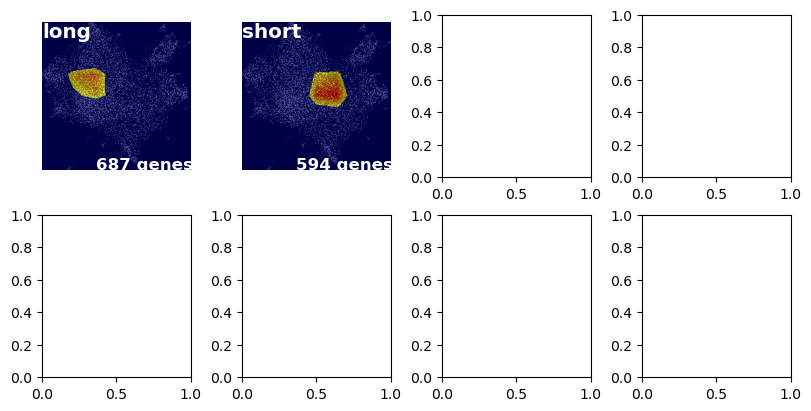

In [ ]:
_ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)

In [ ]:
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[1:10])}...")

  687 features selected for long: RFC2, PAX8, PTPN21, ESRRA, GAS6, MMP14, SRP14, RPL24, SEPTIN2...
  594 features selected for short: CYP2A6, BAD, PRPF8, CAPNS1, RPL35, EIF3D, SRP14, HNRNPA1, EIF3F...
